In [1]:
import networkx as nx
import EoN
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

In [2]:
# function to analyze a list
def mean_var_std(list_aim):
    return (round(np.mean(list_aim), 3),
            round(np.var(list_aim), 3),
            round(np.std(list_aim), 3))


In [3]:
# function for serach for the agents on each group
def I_group(G):
    I = []
    for i in range(N):
        if nx.get_node_attributes(G,'statue')[i]=='I':
            I.append(i)
    return I

def S_group(G): 
    S = []
    for i in range(N):
        if nx.get_node_attributes(G,'statue')[i]=='S':
            S.append(i)
    return S
                
def R_group(G):
    R = []
    for i in range(N):
        if nx.get_node_attributes(G,'statue')[i]=='R':
            R.append(i)
    return R

In [4]:
# function for update the inforamation of each node
def update_time(reulst, G, N):
    for i in range(N):
        if G._node[i]['statue'] == "S":
            for j in range(len(reulst.node_history(i)[1])):
                G._node[i].update({reulst.node_history(i)[1][j]: 
                               reulst.node_history(i)[0][j]})
                G._node[i].update({'S': 0})
        elif G._node[i]['statue'] == "I":
            if len(reulst.node_history(i)[1]) == 2:
                G._node[i].update({"R": reulst.node_history(i)[0][1]})

                
def update_status(G, N):
    for i in range(N):
        if G._node[i]['R']> -0.1:
            G._node[i].update({'statue': "R"})
        elif G._node[i]['I']> - 0.1:
            G._node[i].update({'statue': "I"})
        

def update_from(result, G):
    for i in range(len(result.transmissions())):
        j = result.transmissions()[i][2]
        if G._node[j]['From'] == -1:
            G._node[j].update({'From': result.transmissions()[i][1]})

In [5]:
# simulation based on the time_interval
def simulation_model_unit_time(G,initial_infected_list, initial_recovered_list, infected_rate, 
                    recoverey_rate, time_interval, stage_one_threshold, G_remove_list):
    # the whole recored
    combine_t = []
    combine_I = []
    combine_S = []
    combine_R = []
    
    # set inital input variables
    start_time = 0
    end_time = time_interval
    start_infected_list = initial_infected_list
    start_recovery_list = initial_recovered_list
    num_node = len(G._node)
    
    # run simulation in each time_interval before the first time threshold coming
    while (len(start_infected_list)+len(start_recovery_list))/num_node < stage_one_threshold:
        sim_data =  EoN.Gillespie_SIR(G, infected_rate, recoverey_rate, 
                                      tmin = start_time, tmax=end_time,
                                 initial_infecteds = start_infected_list,
                                 initial_recovereds =  start_recovery_list, return_full_data = True)
        
        # updata information of each node
        update_time(sim_data, G, num_node)
        update_status(G, num_node)
        update_from(sim_data ,G)

        # record the simiulation result
        combine_t = combine_t + sim_data.t().tolist()
        combine_S = combine_S + sim_data.S().tolist()
        combine_I = combine_I + sim_data.I().tolist()
        combine_R = combine_R + sim_data.R().tolist()
        
        # update infotmation of simuailation model
        start_time = sim_data.t()[-1]
        end_time = start_time + time_interval
        start_infected_list = I_group(G)
        start_recovery_list = R_group(G)
   
    # The second stage
    # Remove list from remove_list  
    for i in G_remove_list:
        G.remove_edge(*i)
    
    start_time_stage_2 = start_time
    
    # run the simulation of the second stage after removing edges
    sim_data =  EoN.Gillespie_SIR(G, infected_rate, recoverey_rate, tmin = start_time,
                             initial_infecteds = start_infected_list,
                             initial_recovereds =  start_recovery_list, return_full_data = True)

    # updata information of each node
    update_time(sim_data, G, num_node)
    update_status(G, num_node)
    update_from(sim_data ,G)

    # record the simiulation result
    combine_t = combine_t + sim_data.t().tolist()
    combine_S = combine_S + sim_data.S().tolist()
    combine_I = combine_I + sim_data.I().tolist()
    combine_R = combine_R + sim_data.R().tolist()
      
    return combine_t,combine_S, combine_I,combine_R,start_time_stage_2

In [6]:
# fcuntion to get a sample
def simulation_sample(def_p_newman, def_p_whole_on_stage_2_list, def_prob_edges_remove,repeat_time_input,
                     rho_set_input, tau_input, gamma_input, N_input, neighbor_input):
    
    return_result = []
    
    # preset paramters
    rho_set =  rho_set_input#initial fraction infected
    tau =  tau_input
    #transmission rate
    gamma = gamma_input
    #recovery rate

    # network basic structure
    N = N_input
    neigbor = neighbor_input
    
    # number of run
    repeat_time = repeat_time_input
    
    # build a network
    G_stable = nx.generators.random_graphs.newman_watts_strogatz_graph(N, neigbor, def_p_newman)
    
    # faimly connection
    G_stable_basic_edges_list = []
    for i in range(0,N-1,3):
        G_stable_basic_edges_list.append((i,i+1))
        G_stable_basic_edges_list.append((i+1,i+2))
        G_stable_basic_edges_list.append((i,i+2))
    G_stable_edges_list = [e for e in G_stable.edges]
    long_dis_edges_list = [i for i in G_stable_edges_list if i not in G_stable_basic_edges_list]
    
    # degree of the network
    N_degree_list = []
    for i in range(N):
        N_degree_list = N_degree_list +[G_stable.degree(i)] 
    network_av_deg = mean_var_std(N_degree_list)[0]
    
    # diameter of the network
    G_diameter = nx.diameter(G_stable)
    
    #average culster conefficient of the network
    G_average_clustering = nx.average_clustering(G_stable)
    
    # random pick remove list from non-neighbor edages   
    G_stable_remove_list = random.sample(long_dis_edges_list, 
                                         round(len(long_dis_edges_list)*def_prob_edges_remove))
    
    # inital informaion of each node
    for i in range(N):
        G_stable._node[i].update({'name':i})
        G_stable._node[i].update({'statue':'S'})
        G_stable._node[i].update({'From': -1})
        G_stable._node[i].update({'S': 0})
        G_stable._node[i].update({'I': -1})
        G_stable._node[i].update({'R': -1})    
    
    # random pick the inital infected list 
    initial_infected_list = random.sample(range(N), round(N*rho_set))
    initial_recovered_list = []
    for i in initial_infected_list:
        G_stable._node[i]['I'] = 0
        G_stable._node[i]['statue'] = 'I'
        G_stable._node[i]['From'] = None
    
    # run the simulation on each threshold
    for stage_one_threshold in def_p_whole_on_stage_2_list:
        # recored each iteration
        w_final_sus_num = []
        w_final_sus_time = []
        w_infected_peak = [] 
        w_infected_peak_time = []
        w_at_time = []
    
        time_line_list = []
        arr_record_S = []
        arr_record_I = []
        arr_record_R = []

        for i in range(repeat_time):
            G = G_stable.copy()
            result_data = simulation_model_unit_time(G,initial_infected_list, initial_recovered_list, 
                                                     tau,gamma, 0.5, stage_one_threshold, G_stable_remove_list)
            # record all data
            result_t = result_data[0]
            result_S = result_data[1]
            result_I = result_data[2]
            result_R = result_data[3]

            final_sus_num = result_S[-1]
            final_sus_time =  result_t[result_S.index(final_sus_num)]
            infected_peak = max(result_I)
            infected_peak_time = result_t[result_I.index(infected_peak)]
            
            w_final_sus_num.append(final_sus_num)
            w_final_sus_time.append(final_sus_time)
            w_infected_peak.append(infected_peak)
            w_infected_peak_time.append(infected_peak_time)
            w_at_time.append(result_data[4])
            
            # combine all data following the time line
            result_t_standard = [i for i in np.arange(0, result_t[-1], 0.2)]
            index_time_line = [result_t.index(min(result_t, 
                                               key=lambda x:abs(x-i))) for i in result_t_standard] 
            result_S_standard = [result_S[i] for i in index_time_line]
            result_I_standard = [result_I[i] for i in index_time_line]
            result_R_standard = [result_R[i] for i in index_time_line]

            if len(time_line_list)<len(result_t_standard):
                for i in [i for i in result_t_standard if i not in time_line_list]:
                    arr_record_S.append([i])
                    arr_record_I.append([i])
                    arr_record_R.append([i])
                time_line_list = result_t_standard

            for i in range(len(result_t_standard)):
                arr_record_S[i].append(result_S_standard[i])
                arr_record_I[i].append(result_I_standard[i])
                arr_record_R[i].append(result_R_standard[i])


        plt.title("{}% social distancing is applied in {} days ".format(def_prob_edges_remove*100, mean_var_std(w_at_time)[0]))
        plot_mean_uppper_lower(time_line_list, arr_record_S, arr_record_I,
                    arr_record_R,  max(w_final_sus_time))

        
        return_result.append([N+1,def_p_newman, network_av_deg, G_diameter, 
                              G_average_clustering, def_prob_edges_remove, stage_one_threshold,
                              mean_var_std(w_at_time)[0],mean_var_std(w_at_time)[2],
                              mean_var_std(w_infected_peak)[0], mean_var_std(w_infected_peak)[2], 
                              mean_var_std(w_infected_peak_time)[0],mean_var_std(w_infected_peak_time)[2], 
                              mean_var_std(w_final_sus_num)[0], mean_var_std(w_final_sus_num)[2], 
                              mean_var_std(w_final_sus_time)[0],mean_var_std(w_final_sus_time)[2]])
    return return_result
        

In [7]:
# plot the figure
def plot_mean_uppper_lower (t_list_stand, S_list_stand, I_list_stand, R_list_stand, finished_time):
    
    S_mean = [mean_var_std(S_list_stand[i][1:])[0] for i in range(len(S_list_stand))]
    S_lowerbound  = [mean_var_std(S_list_stand[i][1:])[0]-
                     mean_var_std(S_list_stand[i][1:])[2] for i in range(len(S_list_stand))]
    S_upperbound  = [mean_var_std(S_list_stand[i][1:])[0]+
                     mean_var_std(S_list_stand[i][1:])[2] for i in range(len(S_list_stand))]
    
    I_mean = [mean_var_std(I_list_stand[i][1:])[0] for i in range(len(I_list_stand))]
    I_lowerbound  = [mean_var_std(I_list_stand[i][1:])[0]-
                     mean_var_std(I_list_stand[i][1:])[2] for i in range(len(I_list_stand))]
    I_upperbound  = [mean_var_std(I_list_stand[i][1:])[0]+
                     mean_var_std(I_list_stand[i][1:])[2] for i in range(len(I_list_stand))]
    
    R_mean = [mean_var_std(R_list_stand[i][1:])[0] for i in range(len(R_list_stand))]
    R_lowerbound  = [mean_var_std(R_list_stand[i][1:])[0]-
                     mean_var_std(R_list_stand[i][1:])[2] for i in range(len(R_list_stand))]
    R_upperbound  = [mean_var_std(R_list_stand[i][1:])[0]+
                     mean_var_std(R_list_stand[i][1:])[2] for i in range(len(R_list_stand))]
    
    fi_in =t_list_stand.index(min(t_list_stand,key=lambda x:abs(x-finished_time))) 
    
    plt.plot(t_list_stand[:fi_in], S_mean[:fi_in], color = 'blue')
    plt.fill_between(t_list_stand[:fi_in], S_lowerbound[:fi_in],S_upperbound[:fi_in], facecolor = 'blue', alpha=0.5,label='S' )
    plt.plot(t_list_stand[:fi_in], I_mean[:fi_in], color = 'orange')
    plt.fill_between(t_list_stand[:fi_in], I_lowerbound[:fi_in],I_upperbound[:fi_in], facecolor = 'orange', alpha=0.5,label='I' )
    plt.plot(t_list_stand[:fi_in], R_mean[:fi_in], color = 'green')
    plt.fill_between(t_list_stand[:fi_in], R_lowerbound[:fi_in],R_upperbound[:fi_in], facecolor = 'green', alpha=0.5,label='R' )
    plt.legend()
    plt.show()

# Example: simulation for one setting and plot the result

In [8]:
# create the dataset
analysis_dataset = pd.DataFrame(columns = ['N','newman_p','av_deg','dia','ave_clu','policy_power','threshold',
                                           'a_t_m','a_t_std','I_P_N_m','I_P_N_std','I_P_T_m','I_P_T_std',
                                           'S_F_N_m','S_F_N_std','S_F_T_m','S_F_T_std'])

In [10]:
# preset paramters

#initial fraction infected
rho_set = 0.002
#transmission rate
tau = 0.14
#recovery rate
gamma = 0.06

# phyiscal network structure based on watts_strogatz_grap 
N = 1499
neighbor = 4

# the run of time
repeat_time = 10
# the probaility to build new link to other agents 
p_newman_list = [0.5]
# the momennt when the policy is applied
p_whole_on_stage_2 = [0.1]
# the probability of a social link being removed
prob_edges_remove_list =[0.5]

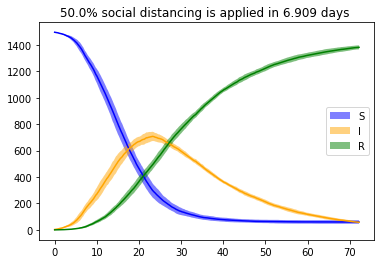

In [11]:
# record all result of the data
analysis_time  = 0
# simulation the SIR model with different settings
for p_newman in p_newman_list:
    for prob_edges_remove in prob_edges_remove_list:
        result_simulation  = simulation_sample(p_newman, p_whole_on_stage_2,
                                               prob_edges_remove,repeat_time,
                                               rho_set, tau, gamma, N, neighbor)
        for k in range(len(result_simulation)):
            analysis_dataset.loc[analysis_time] = result_simulation[k]
            analysis_time +=1


In [12]:
analysis_dataset

,N,newman_p,av_deg,dia,ave_clu,policy_power,threshold,a_t_m,a_t_std,I_P_N_m,I_P_N_std,I_P_T_m,I_P_T_std,S_F_N_m,S_F_N_std,S_F_T_m,S_F_T_std
0,1500.0,0.5,5.985,8.0,0.233897,0.5,0.1,6.909,0.594,715.2,32.75,23.06,1.098,59.6,13.588,57.922,6.328


# Simulation for all settings

In [ ]:
# create the dataset
analysis_dataset = pd.DataFrame(columns = ['N','newman_p','av_deg','dia','ave_clu','policy_power','threshold',
                                           'a_t_m','a_t_std','I_P_N_m','I_P_N_std','I_P_T_m','I_P_T_std',
                                           'S_F_N_m','S_F_N_std','S_F_T_m','S_F_T_std'])

In [ ]:
# preset paramters

#initial fraction infected
rho_set = 0.002
#transmission rate
tau = 0.14
#recovery rate
gamma = 0.06

# phyiscal network structure based on watts_strogatz_grap 
N = 1499
neighbor = 4

# the run of time
repeat_time = 10
# three dimensions paramters 
# the probaility to build new link to other agents 
p_newman_list = [0.3,0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
# the momennt when the policy is applied
p_whole_on_stage_2 = [0.01, 0.04, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
# the probability of a social link being removed
prob_edges_remove_list =[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]

In [ ]:
# record all result of the data
analysis_time  = 0
# simulation the SIR model with different settings
for p_newman in p_newman_list:
    for prob_edges_remove in prob_edges_remove_list:
        result_simulation  = simulation_sample(p_newman, p_whole_on_stage_2,
                                               prob_edges_remove,repeat_time,
                                               rho_set, tau, gamma, N, neighbor)
        for k in range(len(result_simulation)):
            analysis_dataset.loc[analysis_time] = result_simulation[k]
            analysis_time +=1
            
        

In [ ]:
analysis_dataset